In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [30]:
from torchvision.datasets import MNIST
from torchvision import transforms

import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset

mean, std = 0.1307, 0.3081

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]

train_dataset = loadDataset('MNIST', classes, instances, mode='train')
test_dataset = loadDataset('MNIST', classes, instances, mode='test')


'''
train_dataset = MNIST('/Neutron3/lovish.chum/MNIST/', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('/Neutron3/lovish.chum/MNIST/', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
                            '''

n_classes = 10

## Common setup

In [31]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [32]:
def showLossHist(lossHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(lossHist['trainLoss']))

    y1 = lossHist['trainLoss']
    y2 = lossHist['valLoss']

    plt.plot(x, y1, label='Training Loss')
    plt.plot(x, y2, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Triplet Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [33]:
# Set up data loaders
import torch.utils.data
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet(1)
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
    
    
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [34]:
print train_loader.dataset

Dataset MNIST
    Number of datapoints: 50000
    Split: train
    Root Location: /Neutron3/lovish.chum//MNIST/
    Transforms (if any): <torchvision.transforms.Compose object at 0x7fa9f1819c50>
    Target Transforms (if any): None


Train: [0/50000 (0%)]	Loss: 2.350868	Accuracy: 8.984375
Train: [12800/50000 (26%)]	Loss: 2.707904	Accuracy: 22.7711397059
Train: [25600/50000 (51%)]	Loss: 1.122500	Accuracy: 40.3968131188
Train: [38400/50000 (77%)]	Loss: 0.608985	Accuracy: 54.4184602649
Epoch: 1/20. Train set: Average loss: 1.2480	Accuracy: 62.666
Epoch: 1/20. Validation set: Average loss: 0.3488	Accuracy: 92.77
Train: [0/50000 (0%)]	Loss: 0.504814	Accuracy: 91.40625
Train: [12800/50000 (26%)]	Loss: 0.320516	Accuracy: 93.5738357843
Train: [25600/50000 (51%)]	Loss: 0.246624	Accuracy: 94.1986386139
Train: [38400/50000 (77%)]	Loss: 0.274336	Accuracy: 94.3061879139
Epoch: 2/20. Train set: Average loss: 0.2711	Accuracy: 94.614
Epoch: 2/20. Validation set: Average loss: 0.1670	Accuracy: 96.39
Train: [0/50000 (0%)]	Loss: 0.194781	Accuracy: 96.09375
Train: [12800/50000 (26%)]	Loss: 0.198496	Accuracy: 95.8869485294
Train: [25600/50000 (51%)]	Loss: 0.162034	Accuracy: 96.109220297
Train: [38400/50000 (77%)]	Loss: 0.152782	Accurac

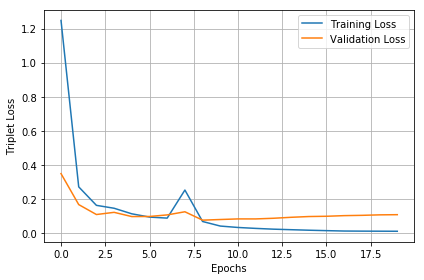

In [35]:
lossDict = fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])
showLossHist(lossDict)

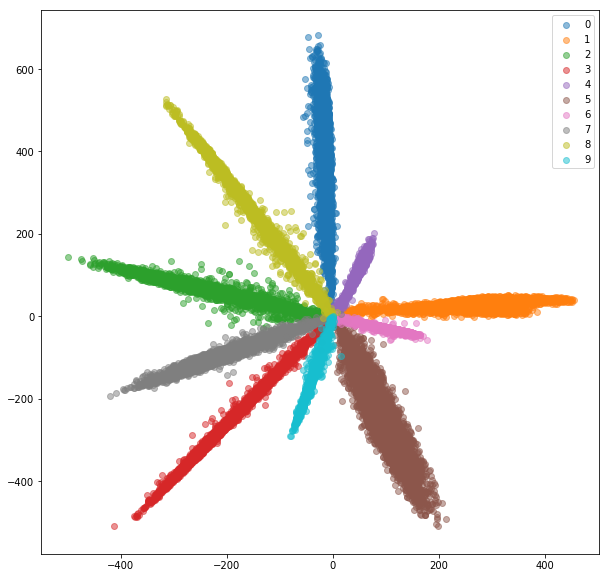

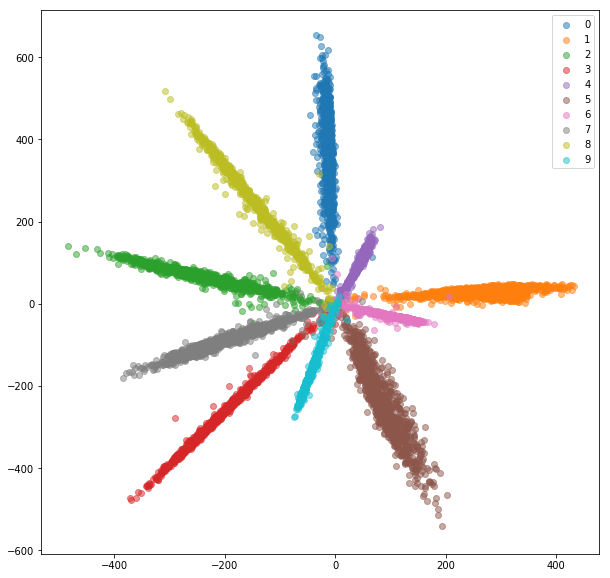

In [36]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [37]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet(1)
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 0.215189
Train: [12800/50000 (26%)]	Loss: 0.069586
Train: [25600/50000 (51%)]	Loss: 0.041401
Train: [38400/50000 (77%)]	Loss: 0.030995
Epoch: 1/20. Train set: Average loss: 0.0427
Epoch: 1/20. Validation set: Average loss: 0.0238
Train: [0/50000 (0%)]	Loss: 0.030704
Train: [12800/50000 (26%)]	Loss: 0.020528
Train: [25600/50000 (51%)]	Loss: 0.018833
Train: [38400/50000 (77%)]	Loss: 0.015305
Epoch: 2/20. Train set: Average loss: 0.0171
Epoch: 2/20. Validation set: Average loss: 0.0133
Train: [0/50000 (0%)]	Loss: 0.014002
Train: [12800/50000 (26%)]	Loss: 0.011678
Train: [25600/50000 (51%)]	Loss: 0.010910
Train: [38400/50000 (77%)]	Loss: 0.009111
Epoch: 3/20. Train set: Average loss: 0.0102
Epoch: 3/20. Validation set: Average loss: 0.0111
Train: [0/50000 (0%)]	Loss: 0.012711
Train: [12800/50000 (26%)]	Loss: 0.007778
Train: [25600/50000 (51%)]	Loss: 0.007489
Train: [38400/50000 (77%)]	Loss: 0.006032
Epoch: 4/20. Train set: Average loss: 0.0068
Epoch: 4/20. Valid

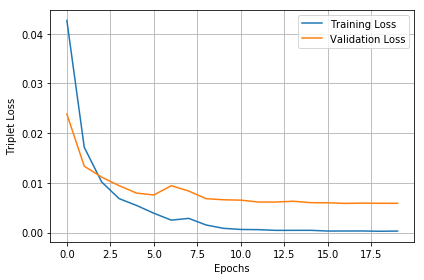

In [38]:
lossDict = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

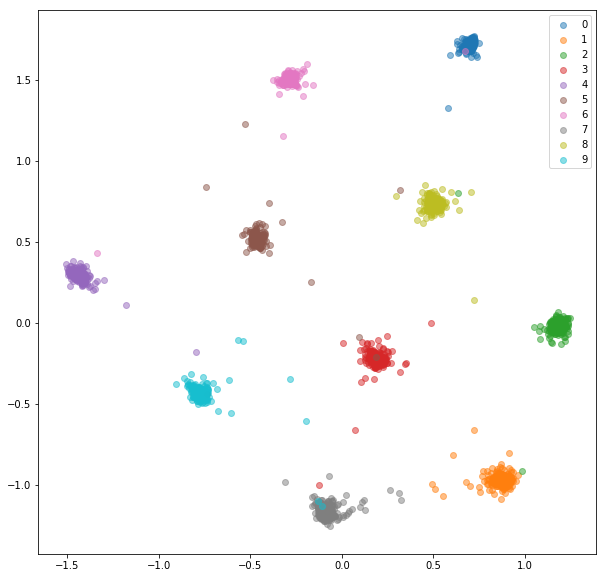

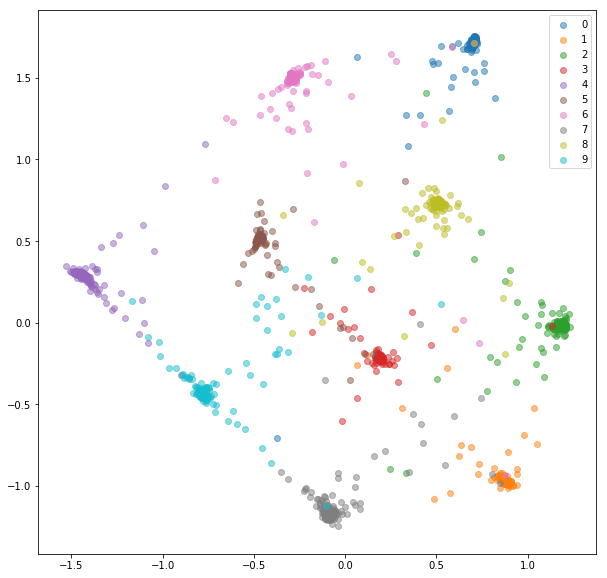

In [39]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [40]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet(1)
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 0.999783
Train: [12800/50000 (26%)]	Loss: 0.303426
Train: [25600/50000 (51%)]	Loss: 0.126958
Train: [38400/50000 (77%)]	Loss: 0.098435
Epoch: 1/20. Train set: Average loss: 0.1560
Epoch: 1/20. Validation set: Average loss: 0.0629
Train: [0/50000 (0%)]	Loss: 0.122560
Train: [12800/50000 (26%)]	Loss: 0.059483
Train: [25600/50000 (51%)]	Loss: 0.057879
Train: [38400/50000 (77%)]	Loss: 0.047717
Epoch: 2/20. Train set: Average loss: 0.0529
Epoch: 2/20. Validation set: Average loss: 0.0312
Train: [0/50000 (0%)]	Loss: 0.060565
Train: [12800/50000 (26%)]	Loss: 0.034375
Train: [25600/50000 (51%)]	Loss: 0.036194
Train: [38400/50000 (77%)]	Loss: 0.032259
Epoch: 3/20. Train set: Average loss: 0.0339
Epoch: 3/20. Validation set: Average loss: 0.0483
Train: [0/50000 (0%)]	Loss: 0.025025
Train: [12800/50000 (26%)]	Loss: 0.032645
Train: [25600/50000 (51%)]	Loss: 0.035339
Train: [38400/50000 (77%)]	Loss: 0.025674
Epoch: 4/20. Train set: Average loss: 0.0305
Epoch: 4/20. Valid

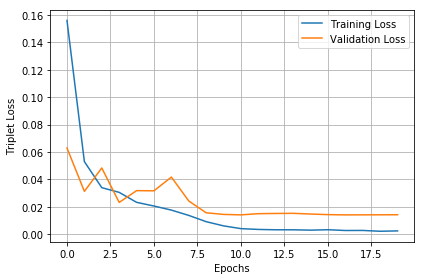

In [41]:
lossDict = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

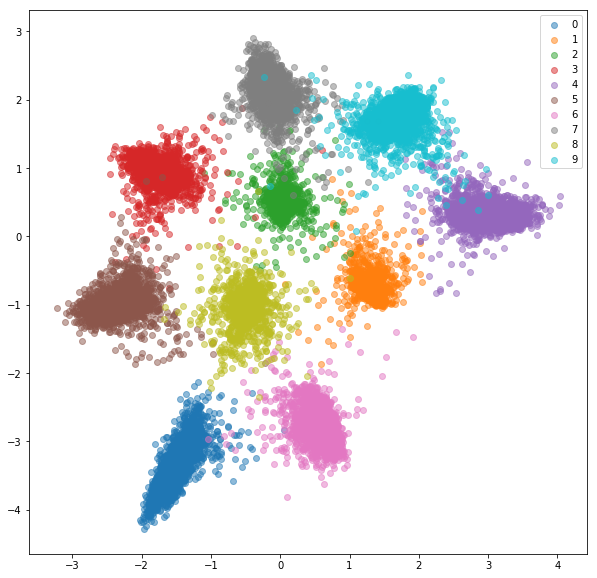

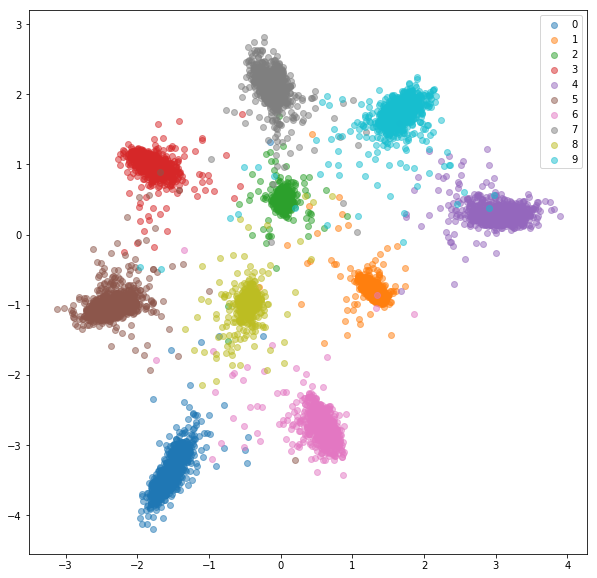

In [42]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection

In [5]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, AllPositivePairSelector(balance=True))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [7]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

Train: [0/50000 (0%)]	Loss: 0.478927
Train: [12500/50000 (25%)]	Loss: 0.140228
Train: [25000/50000 (50%)]	Loss: 0.080323
Train: [37500/50000 (75%)]	Loss: 0.062626
Epoch: 1/20. Train set: Average loss: 0.0863
Epoch: 1/20. Validation set: Average loss: 0.0454
Train: [0/50000 (0%)]	Loss: 0.037509
Train: [12500/50000 (25%)]	Loss: 0.042047
Train: [25000/50000 (50%)]	Loss: 0.036692
Train: [37500/50000 (75%)]	Loss: 0.034240
Epoch: 2/20. Train set: Average loss: 0.0356
Epoch: 2/20. Validation set: Average loss: 0.0279
Train: [0/50000 (0%)]	Loss: 0.028422
Train: [12500/50000 (25%)]	Loss: 0.024515
Train: [25000/50000 (50%)]	Loss: 0.022728
Train: [37500/50000 (75%)]	Loss: 0.021454
Epoch: 3/20. Train set: Average loss: 0.0225
Epoch: 3/20. Validation set: Average loss: 0.0181
Train: [0/50000 (0%)]	Loss: 0.016198
Train: [12500/50000 (25%)]	Loss: 0.014935
Train: [25000/50000 (50%)]	Loss: 0.015550
Train: [37500/50000 (75%)]	Loss: 0.017550
Epoch: 4/20. Train set: Average loss: 0.0159
Epoch: 4/20. Valid

{'trainLoss': [0.08626967095699742,
  0.03558389836894208,
  0.022473878288014452,
  0.01594608264680409,
  0.011606330112858334,
  0.008492093762598145,
  0.005318350155706793,
  0.0057313376949894145,
  0.0023776755045781185,
  0.0017298000378255737,
  0.0015040529608415282,
  0.0013107601604389317,
  0.0012340456424000201,
  0.001115969075393119,
  0.0010307030920489182,
  0.0009872991644049615,
  0.0008525535398181621,
  0.0007781300976891164,
  0.0008855943735361324,
  0.0007639547648936762],
 'valLoss': [0.04543370567262173,
  0.02788122333586216,
  0.018052305886521937,
  0.017396744526922702,
  0.016645627690013497,
  0.0152022103080526,
  0.014845670759677887,
  0.012689171091187746,
  0.010529167079948821,
  0.010518709878670051,
  0.01083495665807277,
  0.010823997695115394,
  0.01021300744614564,
  0.01049597763485508,
  0.01153495328471763,
  0.009409364033490419,
  0.011185658539761788,
  0.008894824335584417,
  0.01195909003727138,
  0.010369768130476586]}

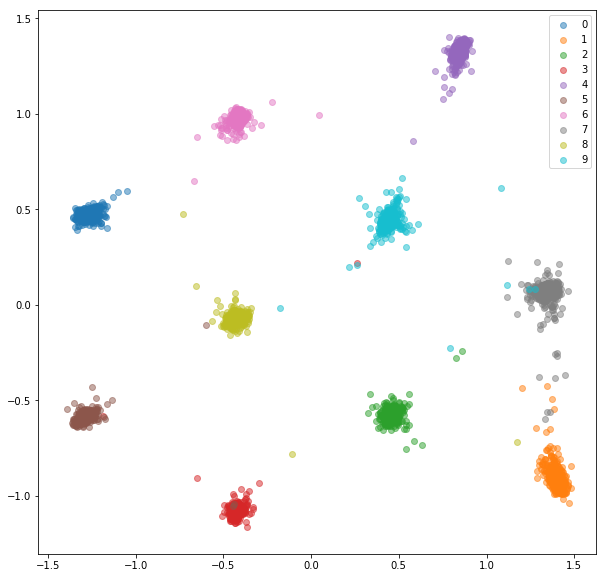

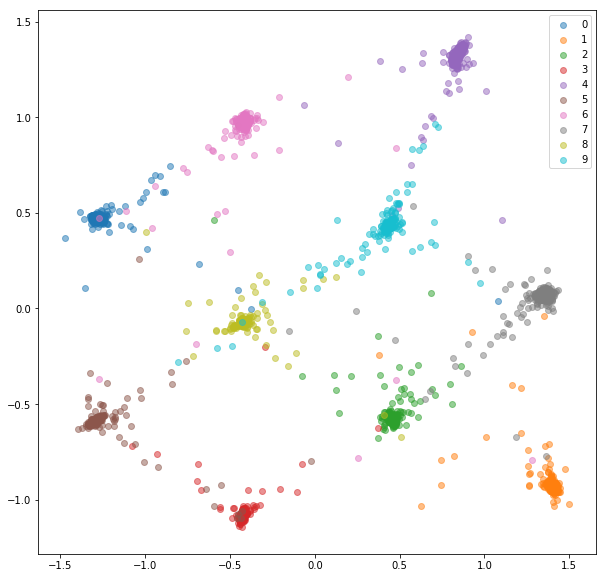

In [8]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

### Hard Negative pair selection

Train: [0/50000 (0%)]	Loss: 0.495858
Train: [12500/50000 (25%)]	Loss: 0.305435
Train: [25000/50000 (50%)]	Loss: 0.158008
Train: [37500/50000 (75%)]	Loss: 0.101823
Epoch: 1/20. Train set: Average loss: 0.1635
Epoch: 1/20. Validation set: Average loss: 0.0685
Train: [0/50000 (0%)]	Loss: 0.057261
Train: [12500/50000 (25%)]	Loss: 0.064055
Train: [25000/50000 (50%)]	Loss: 0.057899
Train: [37500/50000 (75%)]	Loss: 0.050779
Epoch: 2/20. Train set: Average loss: 0.0525
Epoch: 2/20. Validation set: Average loss: 0.0369
Train: [0/50000 (0%)]	Loss: 0.057285
Train: [12500/50000 (25%)]	Loss: 0.037198
Train: [25000/50000 (50%)]	Loss: 0.033301
Train: [37500/50000 (75%)]	Loss: 0.028035
Epoch: 3/20. Train set: Average loss: 0.0310
Epoch: 3/20. Validation set: Average loss: 0.0374
Train: [0/50000 (0%)]	Loss: 0.009303
Train: [12500/50000 (25%)]	Loss: 0.025078
Train: [25000/50000 (50%)]	Loss: 0.026486
Train: [37500/50000 (75%)]	Loss: 0.020786
Epoch: 4/20. Train set: Average loss: 0.0214
Epoch: 4/20. Valid

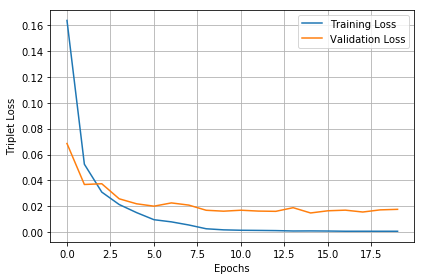

In [27]:
margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

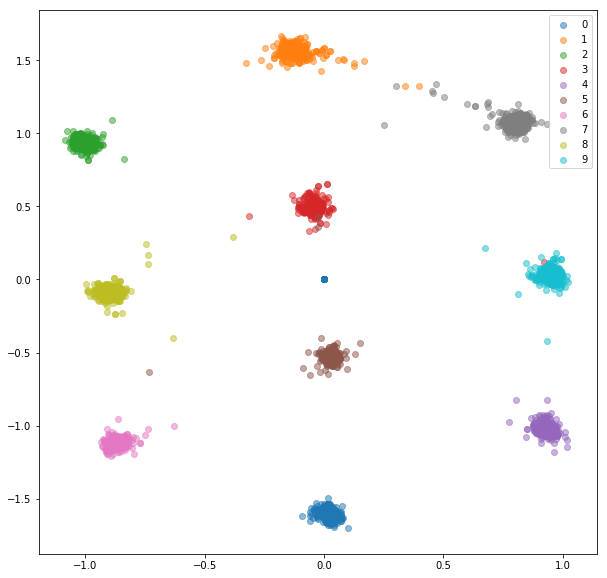

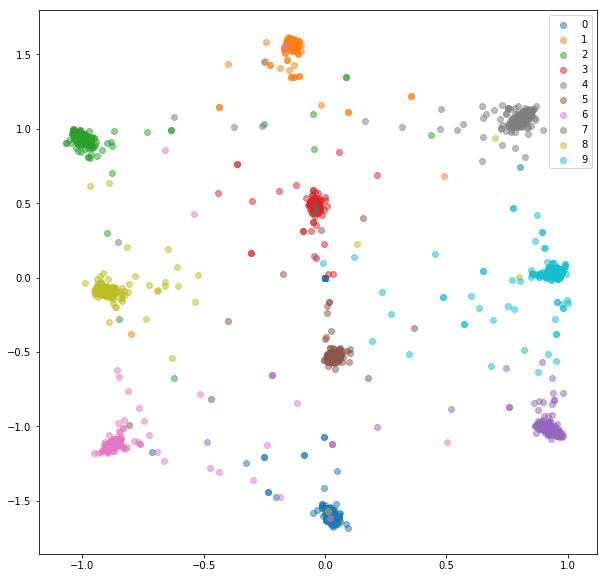

In [28]:
train_embeddings, train_labels = extract_embeddings(online_train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(online_test_loader, model)
plot_embeddings(val_embeddings, val_labels)

## Online triplet selection

### Random Negative Triplet Selection

In [9]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

# where is the pairing being done ??
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [10]:
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

Train: [0/50000 (0%)]	Loss: 0.999881	Average nonzero triplets: 3000.0
Train: [12500/50000 (25%)]	Loss: 0.972031	Average nonzero triplets: 2681.31372549
Train: [25000/50000 (50%)]	Loss: 0.973049	Average nonzero triplets: 2356.43564356
Train: [37500/50000 (75%)]	Loss: 0.979224	Average nonzero triplets: 2099.96688742
Epoch: 1/20. Train set: Average loss: 0.9713	Average nonzero triplets: 1928.12562814
Epoch: 1/20. Validation set: Average loss: 1.0778	Average nonzero triplets: 1083.71794872
Train: [0/50000 (0%)]	Loss: 1.338169	Average nonzero triplets: 1154.0
Train: [12500/50000 (25%)]	Loss: 0.964622	Average nonzero triplets: 1136.29411765
Train: [25000/50000 (50%)]	Loss: 1.009185	Average nonzero triplets: 1049.64356436
Train: [37500/50000 (75%)]	Loss: 0.982425	Average nonzero triplets: 1003.35761589
Epoch: 2/20. Train set: Average loss: 0.9989	Average nonzero triplets: 965.648241206
Epoch: 2/20. Validation set: Average loss: 0.9615	Average nonzero triplets: 716.794871795
Train: [0/50000 (0

Train: [0/50000 (0%)]	Loss: 0.309802	Average nonzero triplets: 1.0
Train: [12500/50000 (25%)]	Loss: 0.252555	Average nonzero triplets: 32.8823529412
Train: [25000/50000 (50%)]	Loss: 0.200951	Average nonzero triplets: 28.2178217822
Train: [37500/50000 (75%)]	Loss: 0.277303	Average nonzero triplets: 27.5430463576
Epoch: 18/20. Train set: Average loss: 0.2466	Average nonzero triplets: 27.6180904523
Epoch: 18/20. Validation set: Average loss: 1.7235	Average nonzero triplets: 275.358974359
Train: [0/50000 (0%)]	Loss: 0.038858	Average nonzero triplets: 2.0
Train: [12500/50000 (25%)]	Loss: 0.192947	Average nonzero triplets: 17.0392156863
Train: [25000/50000 (50%)]	Loss: 0.203445	Average nonzero triplets: 17.6435643564
Train: [37500/50000 (75%)]	Loss: 0.253581	Average nonzero triplets: 26.2450331126
Epoch: 19/20. Train set: Average loss: 0.2300	Average nonzero triplets: 26.2261306533
Epoch: 19/20. Validation set: Average loss: 1.4237	Average nonzero triplets: 291.615384615
Train: [0/50000 (0%)

{'trainLoss': [0.9713371258285177,
  0.9988584605293658,
  1.0284774493632005,
  1.0593679205856132,
  1.0469768137189013,
  1.1892732187880943,
  1.0965813739066148,
  1.1067035395895417,
  0.9290868590525048,
  0.6783826634587355,
  0.5642660387122451,
  0.40174146867052996,
  0.34959987030556455,
  0.32876937596791955,
  0.22354411586520062,
  0.28776575774703195,
  0.207585005585722,
  0.24661923776469638,
  0.22998184258651794,
  0.18930900770815173],
 'valLoss': [1.077822083234787,
  0.961476731300354,
  1.1428971409797668,
  1.163454832136631,
  0.9308608710765839,
  0.9236084163188935,
  1.1153828546404838,
  1.7695010170340537,
  1.1026812642812729,
  1.0876103512942792,
  1.1140957064926624,
  1.665601734444499,
  1.2753336276859044,
  1.7931512627750634,
  1.5137941744178534,
  1.3291608057916164,
  1.4166717447340489,
  1.7235407806932925,
  1.423675111681223,
  1.4763039683923125]}

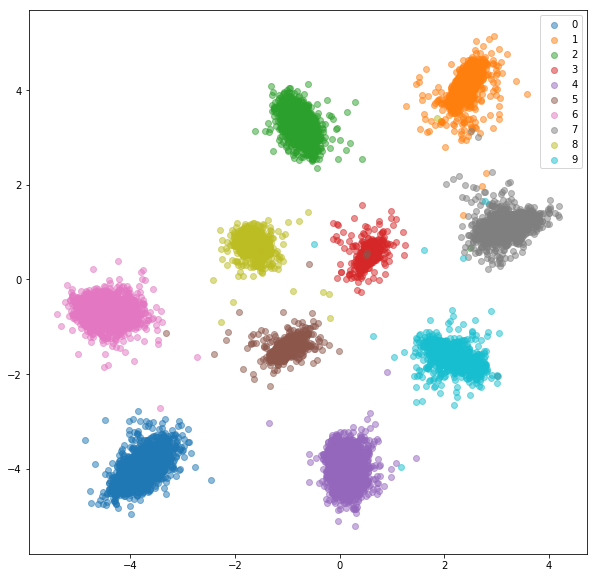

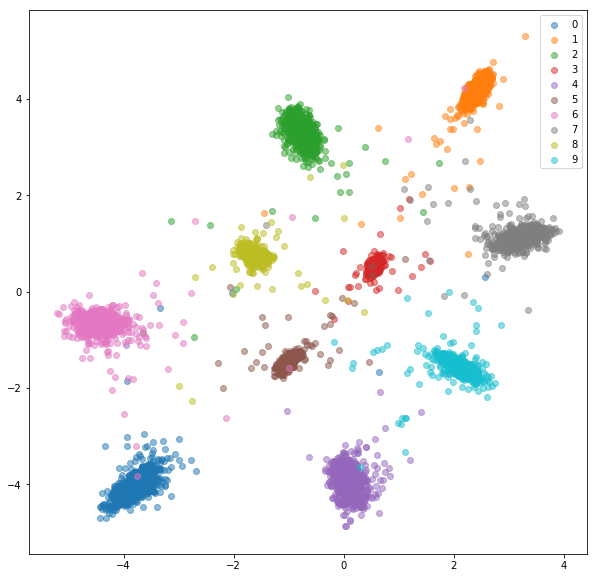

In [11]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)

### Semi Hard Negative triplets

Train: [0/50000 (0%)]	Loss: 0.999628	Average nonzero triplets: 2989.0
Train: [12500/50000 (25%)]	Loss: 0.950433	Average nonzero triplets: 1478.03921569
Train: [25000/50000 (50%)]	Loss: 0.949416	Average nonzero triplets: 1012.21782178
Train: [37500/50000 (75%)]	Loss: 0.949740	Average nonzero triplets: 763.324503311
Epoch: 1/20. Train set: Average loss: 0.9498	Average nonzero triplets: 625.733668342
Epoch: 1/20. Validation set: Average loss: 0.9265	Average nonzero triplets: 179.256410256
Train: [0/50000 (0%)]	Loss: 0.947610	Average nonzero triplets: 131.0
Train: [12500/50000 (25%)]	Loss: 0.949088	Average nonzero triplets: 137.745098039
Train: [25000/50000 (50%)]	Loss: 0.949827	Average nonzero triplets: 127.346534653
Train: [37500/50000 (75%)]	Loss: 0.949551	Average nonzero triplets: 103.78807947
Epoch: 2/20. Train set: Average loss: 0.9497	Average nonzero triplets: 87.8844221106
Epoch: 2/20. Validation set: Average loss: 0.9256	Average nonzero triplets: 25.4615384615
Train: [0/50000 (0%)

Epoch: 17/20. Train set: Average loss: 0.5839	Average nonzero triplets: 1.4472361809
Epoch: 17/20. Validation set: Average loss: 0.5237	Average nonzero triplets: 1.25641025641
Train: [0/50000 (0%)]	Loss: 0.000000	Average nonzero triplets: 1.0
Train: [12500/50000 (25%)]	Loss: 17.923662	Average nonzero triplets: 1.25490196078
Train: [25000/50000 (50%)]	Loss: 500.995337	Average nonzero triplets: 1.29702970297
Train: [37500/50000 (75%)]	Loss: 0.623813	Average nonzero triplets: 1.29801324503
Epoch: 18/20. Train set: Average loss: 131.8778	Average nonzero triplets: 1.28140703518
Epoch: 18/20. Validation set: Average loss: 0.5704	Average nonzero triplets: 1.25641025641
Train: [0/50000 (0%)]	Loss: 0.899414	Average nonzero triplets: 1.0
Train: [12500/50000 (25%)]	Loss: 91.220843	Average nonzero triplets: 1.29411764706
Train: [25000/50000 (50%)]	Loss: 272.745288	Average nonzero triplets: 1.25742574257
Train: [37500/50000 (75%)]	Loss: 64.827353	Average nonzero triplets: 1.31125827815
Epoch: 19/20

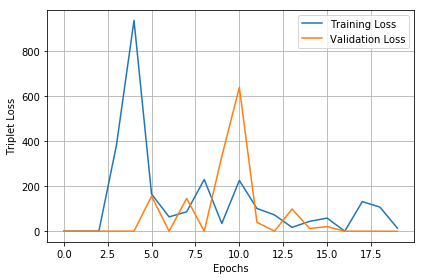

In [23]:
margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(0.1))
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

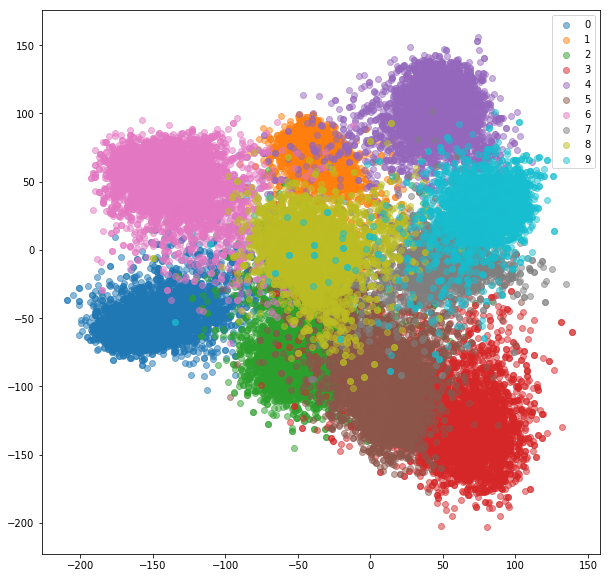

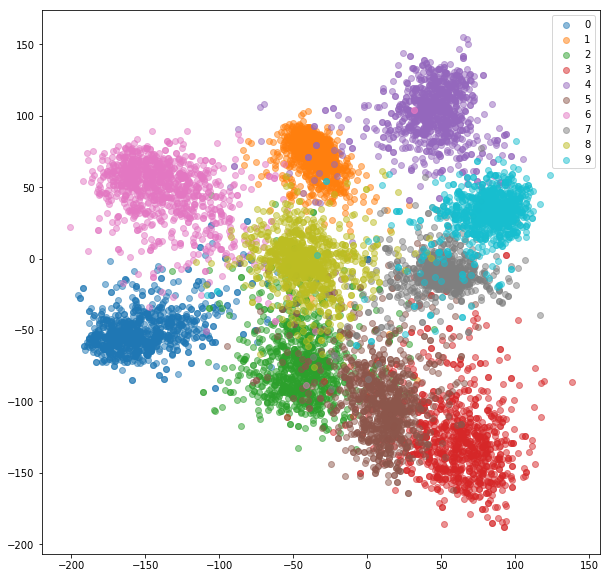

In [24]:
train_embeddings, train_labels = extract_embeddings(online_train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(online_test_loader, model)
plot_embeddings(val_embeddings, val_labels)

### Hardest Negative Only

Train: [0/50000 (0%)]	Loss: 1.000223	Average nonzero triplets: 3000.0
Train: [12500/50000 (25%)]	Loss: 1.000035	Average nonzero triplets: 3000.0
Train: [25000/50000 (50%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [37500/50000 (75%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Epoch: 1/20. Train set: Average loss: 1.0000	Average nonzero triplets: 3000.0
Epoch: 1/20. Validation set: Average loss: 0.9750	Average nonzero triplets: 3000.0
Train: [0/50000 (0%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [12500/50000 (25%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [25000/50000 (50%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [37500/50000 (75%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Epoch: 2/20. Train set: Average loss: 1.0000	Average nonzero triplets: 3000.0
Epoch: 2/20. Validation set: Average loss: 0.9750	Average nonzero triplets: 3000.0
Train: [0/50000 (0%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [12500/5000

Train: [0/50000 (0%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [12500/50000 (25%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [25000/50000 (50%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [37500/50000 (75%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Epoch: 19/20. Train set: Average loss: 1.0000	Average nonzero triplets: 3000.0
Epoch: 19/20. Validation set: Average loss: 0.9750	Average nonzero triplets: 3000.0
Train: [0/50000 (0%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [12500/50000 (25%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [25000/50000 (50%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Train: [37500/50000 (75%)]	Loss: 1.000000	Average nonzero triplets: 3000.0
Epoch: 20/20. Train set: Average loss: 1.0000	Average nonzero triplets: 3000.0
Epoch: 20/20. Validation set: Average loss: 0.9750	Average nonzero triplets: 3000.0


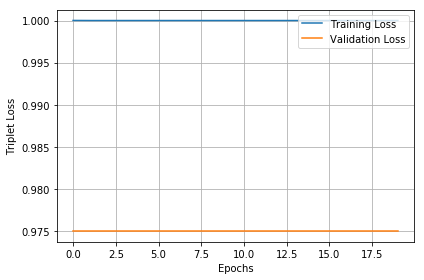

In [25]:
margin = 1.
embedding_net = EmbeddingNet(1)
model = embedding_net
if cuda:
    model.cuda()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

loss_fn = OnlineTripletLoss(margin, HardestNegativeTripletSelector(margin))
lossDict = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

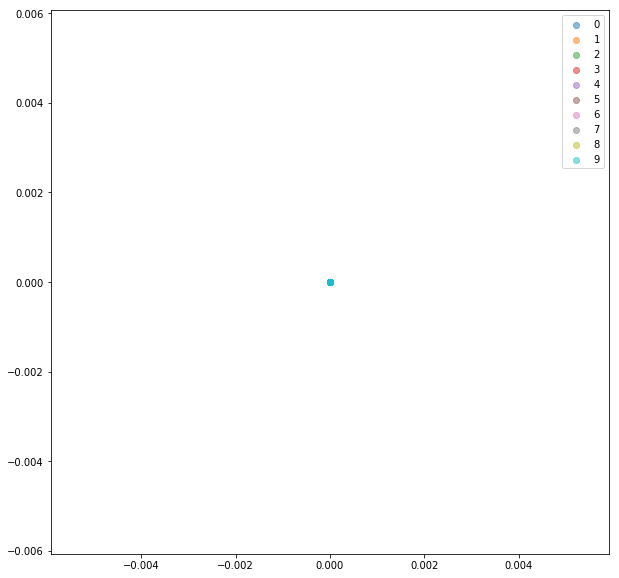

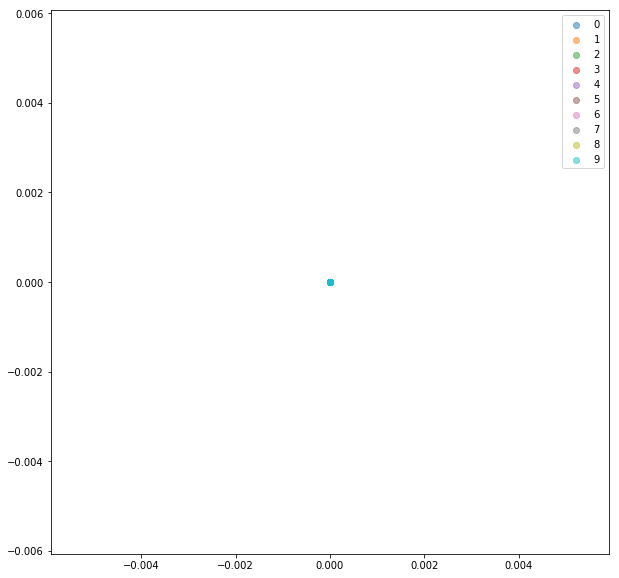

In [26]:
train_embeddings, train_labels = extract_embeddings(online_train_loader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(online_test_loader, model)
plot_embeddings(val_embeddings, val_labels)

## Common Functions

In [ ]:
def showLossHist(lossHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(lossHist['trainLoss']))

    y1 = lossHist['trainLoss']
    y2 = lossHist['valLoss']

    plt.plot(x, y1, label='Training Loss')
    plt.plot(x, y2, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Triplet Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [62]:
from torchvision import transforms

import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset



import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))

    for i in range(10):
        primary_inds = np.where(primary_targets==i)[0]
        
        #primary_tsne = tsne.fit_transform(primary_embeddings[primary_inds])
        #plt.scatter(primary_tsne[:, 0], primary_tsne[:, 1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)
        
        #plt.scatter(primary_embeddings[primary_inds,0], primary_embeddings[primary_inds,1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)
        
        helper_inds = np.where(helper_targets==i)[0]
        
        #helper_tsne = tsne.fit_transform(helper_embeddings[helper_inds])
        #plt.scatter(helper_tsne[:, 0], helper_tsne[:, 1],  marker='o', alpha=0.3, color=colors[i], s=100)
        
        plt.scatter(helper_embeddings[helper_inds,0], helper_embeddings[helper_inds,1],  marker='o', alpha=0.3, color=colors[i], s=100)
                
    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, domain='primary'):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images, domain).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

## Online Pair Selection with MNIST and SVHN

In [57]:
classes = [i for i in range(10)]
instances = [5000 for i in range(10)]

# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )

In [6]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler_primary = BalancedBatchSampler(train_dataset_primary, n_classes=10, n_samples=25)
test_batch_sampler_primary = BalancedBatchSampler(test_dataset_primary, n_classes=10, n_samples=25)

train_batch_sampler_helper = BalancedBatchSampler(train_dataset_helper, n_classes=10, n_samples=25)
test_batch_sampler_helper = BalancedBatchSampler(test_dataset_helper, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


online_train_loader_primary = torch.utils.data.DataLoader(train_dataset_primary, 
                                                          batch_sampler=train_batch_sampler_primary, 
                                                          **kwargs)
online_test_loader_primary = torch.utils.data.DataLoader(test_dataset_primary, 
                                                         batch_sampler=test_batch_sampler_primary, 
                                                         **kwargs)

online_train_loader_helper = torch.utils.data.DataLoader(train_dataset_helper, 
                                                          batch_sampler=train_batch_sampler_helper, 
                                                          **kwargs)
online_test_loader_helper = torch.utils.data.DataLoader(test_dataset_helper, 
                                                         batch_sampler=test_batch_sampler_helper, 
                                                         **kwargs)


# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import OnlineContrastiveLoss2
from utils import AllPositivePairSelector2, HardNegativePairSelector2 # Strategies for selecting pairs within a minibatch
from trainer import fit2

margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(3)

model = SiameseNet(embedding_net_primary, embedding_net_helper)

if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss2(margin, AllPositivePairSelector2(balance=True))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [59]:
lossDict = fit2(online_train_loader_primary,
     online_test_loader_primary,
     online_train_loader_helper,
     online_test_loader_helper,
     model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, mode='contrastive')
showLossHist(lossDict)

Train: [0/50000 (0%)]	Loss: 0.414547
Train: [50/50000 (25%)]	Loss: 0.264450
Train: [100/50000 (50%)]	Loss: 0.250484
Train: [150/50000 (75%)]	Loss: 0.250503
Epoch: 1/20. Train set: Average loss: 0.2548
Epoch: 1/20. Validation set: Average loss: 0.2439
Train: [0/50000 (0%)]	Loss: 0.248891
Train: [50/50000 (25%)]	Loss: 0.250241
Train: [100/50000 (50%)]	Loss: 0.250377
Train: [150/50000 (75%)]	Loss: 0.250118
Epoch: 2/20. Train set: Average loss: 0.2502
Epoch: 2/20. Validation set: Average loss: 0.2436
Train: [0/50000 (0%)]	Loss: 0.250445
Train: [50/50000 (25%)]	Loss: 0.250125
Train: [100/50000 (50%)]	Loss: 0.250047
Train: [150/50000 (75%)]	Loss: 0.250298
Epoch: 3/20. Train set: Average loss: 0.2502
Epoch: 3/20. Validation set: Average loss: 0.2438
Train: [0/50000 (0%)]	Loss: 0.250059
Train: [50/50000 (25%)]	Loss: 0.250103
Train: [100/50000 (50%)]	Loss: 0.250022
Train: [150/50000 (75%)]	Loss: 0.250132
Epoch: 4/20. Train set: Average loss: 0.2501
Epoch: 4/20. Validation set: Average loss: 0.2

{'trainLoss': [0.25482935172439825,
  0.2502299506555904,
  0.25017721115639713,
  0.2501008983212288,
  0.25005260817330294,
  0.2501895638427349,
  0.25009014532722607,
  0.2500689567791091,
  0.2500406498409281,
  0.2499985359232835,
  0.2500220490525467,
  0.25000953320601976,
  0.25001239325060987,
  0.24999427118084647,
  0.24998850443146445,
  0.25002723194734017,
  0.24999732832715968,
  0.2500145302878486,
  0.2500162190108588,
  0.24999946732111653],
 'valLoss': [0.24390695057809353,
  0.243560279160738,
  0.24378083199262618,
  0.2438576675951481,
  0.24390105083584784,
  0.24376974776387214,
  0.24374947585165502,
  0.2437718316912651,
  0.24378412626683713,
  0.2438100203871727,
  0.24379965402185916,
  0.2437597345560789,
  0.24377123080193996,
  0.24381314516067504,
  0.24377562738955022,
  0.24374489076435565,
  0.24375339597463608,
  0.24378824084997178,
  0.24376291558146476,
  0.24376056678593158]}

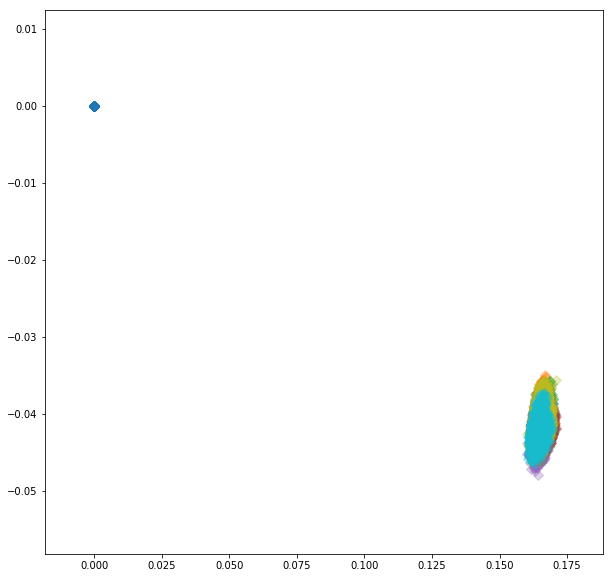

In [61]:
primary_train_embeddings, primary_train_labels = extract_embeddings(online_train_loader_primary, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(online_train_loader_helper, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

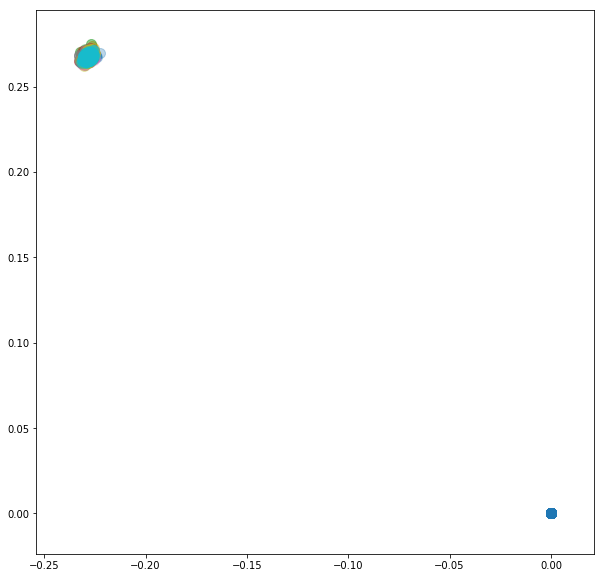

In [63]:
primary_train_embeddings, primary_train_labels = extract_embeddings(online_train_loader_primary, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(online_train_loader_helper, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

## Online Triplet Selection with MNIST and SVHN

In [5]:
classes = [i for i in range(10)]
instances = [5000 for i in range(10)]

# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )

In [13]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler_primary = BalancedBatchSampler(train_dataset_primary, n_classes=10, n_samples=25)
test_batch_sampler_primary = BalancedBatchSampler(test_dataset_primary, n_classes=10, n_samples=25)

train_batch_sampler_helper = BalancedBatchSampler(train_dataset_helper, n_classes=10, n_samples=25)
test_batch_sampler_helper = BalancedBatchSampler(test_dataset_helper, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


online_train_loader_primary = torch.utils.data.DataLoader(train_dataset_primary, 
                                                          batch_sampler=train_batch_sampler_primary, 
                                                          **kwargs)
online_test_loader_primary = torch.utils.data.DataLoader(test_dataset_primary, 
                                                         batch_sampler=test_batch_sampler_primary, 
                                                         **kwargs)

online_train_loader_helper = torch.utils.data.DataLoader(train_dataset_helper, 
                                                          batch_sampler=train_batch_sampler_helper, 
                                                          **kwargs)
online_test_loader_helper = torch.utils.data.DataLoader(test_dataset_helper, 
                                                         batch_sampler=test_batch_sampler_helper, 
                                                         **kwargs)


# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import OnlineTripletLoss2
from utils import AllTripletSelector2,HardestNegativeTripletSelector2, RandomNegativeTripletSelector2, SemihardNegativeTripletSelector2 # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric
from trainer import fit2

margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(3)


model = TripletNet(embedding_net_primary, embedding_net_helper)

if cuda:
    model.cuda()
    
loss_fn = OnlineTripletLoss2(margin, RandomNegativeTripletSelector2(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [14]:
lossDict = fit2(online_train_loader_primary,
     online_test_loader_primary,
     online_train_loader_helper,
     online_test_loader_helper,
     model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, mode='triplet', metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

Train: [0/50000 (0%)]	Loss: 0.999993	Average nonzero triplets: 6250.0
Train: [50/50000 (25%)]	Loss: 0.997214	Average nonzero triplets: 6249.15686275
Train: [100/50000 (50%)]	Loss: 0.796485	Average nonzero triplets: 6210.85148515
Train: [150/50000 (75%)]	Loss: 0.618523	Average nonzero triplets: 6121.42384106
Epoch: 1/20. Train set: Average loss: 0.7386	Average nonzero triplets: 6028.43434343
Epoch: 1/20. Validation set: Average loss: 0.4929	Average nonzero triplets: 5655.23076923
Train: [0/50000 (0%)]	Loss: 0.552428	Average nonzero triplets: 5518.0
Train: [50/50000 (25%)]	Loss: 0.462629	Average nonzero triplets: 5621.07843137
Train: [100/50000 (50%)]	Loss: 0.398649	Average nonzero triplets: 5549.54455446
Train: [150/50000 (75%)]	Loss: 0.377289	Average nonzero triplets: 5525.25827815
Epoch: 2/20. Train set: Average loss: 0.3977	Average nonzero triplets: 5517.73737374
Epoch: 2/20. Validation set: Average loss: 0.3522	Average nonzero triplets: 5595.79487179
Train: [0/50000 (0%)]	Loss: 0.33

Train: [0/50000 (0%)]	Loss: 0.027445	Average nonzero triplets: 4394.0
Train: [50/50000 (25%)]	Loss: 0.030793	Average nonzero triplets: 4776.49019608
Train: [100/50000 (50%)]	Loss: 0.023697	Average nonzero triplets: 4804.42574257
Train: [150/50000 (75%)]	Loss: 0.030584	Average nonzero triplets: 4798.81456954
Epoch: 18/20. Train set: Average loss: 0.0282	Average nonzero triplets: 4791.18181818
Epoch: 18/20. Validation set: Average loss: 0.2645	Average nonzero triplets: 5114.43589744
Train: [0/50000 (0%)]	Loss: 0.021302	Average nonzero triplets: 4781.0
Train: [50/50000 (25%)]	Loss: 0.029891	Average nonzero triplets: 4876.11764706
Train: [100/50000 (50%)]	Loss: 0.027656	Average nonzero triplets: 4831.96039604
Train: [150/50000 (75%)]	Loss: 0.026463	Average nonzero triplets: 4819.66887417
Epoch: 19/20. Train set: Average loss: 0.0274	Average nonzero triplets: 4813.85353535
Epoch: 19/20. Validation set: Average loss: 0.2899	Average nonzero triplets: 5183.53846154
Train: [0/50000 (0%)]	Loss: 

{'trainLoss': [0.7386112444930606,
  0.3976832036719178,
  0.29577217890758706,
  0.22920686209743674,
  0.20581020422355092,
  0.17437206840876376,
  0.1550983814804843,
  0.11825423044237224,
  0.07321471426485464,
  0.05640070676577814,
  0.05193743924375134,
  0.048346196061395334,
  0.041149447055891006,
  0.03764279334420206,
  0.03357788873836398,
  0.033787011639262086,
  0.02732288558036089,
  0.028217025011815507,
  0.027427062469845016,
  0.027512887154113163],
 'valLoss': [0.4929239511489868,
  0.3522300198674202,
  0.29761768095195296,
  0.281573237106204,
  0.26220550276339055,
  0.30103846844285725,
  0.27184014320373534,
  0.279115130379796,
  0.2543562244623899,
  0.24672425389289857,
  0.25841411054134367,
  0.2547438537701964,
  0.2638729685917497,
  0.27724723387509587,
  0.28187932893633844,
  0.2749634120613337,
  0.26493677981197833,
  0.2644858492538333,
  0.28988651242107155,
  0.27417612411081793]}

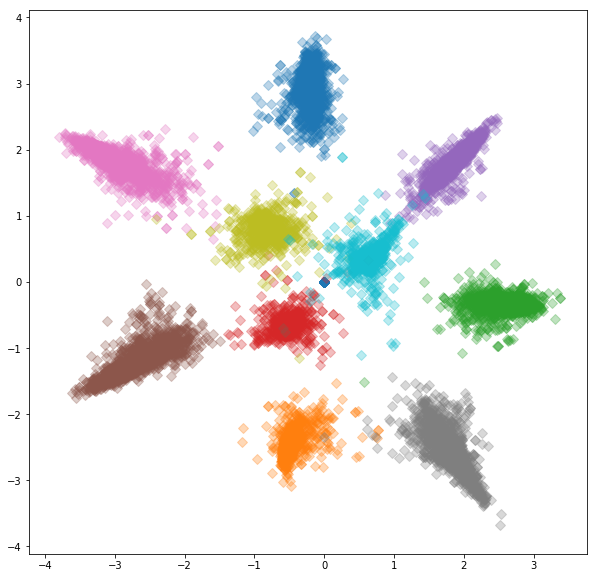

In [52]:
primary_train_embeddings, primary_train_labels = extract_embeddings(online_train_loader_primary, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(online_train_loader_helper, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

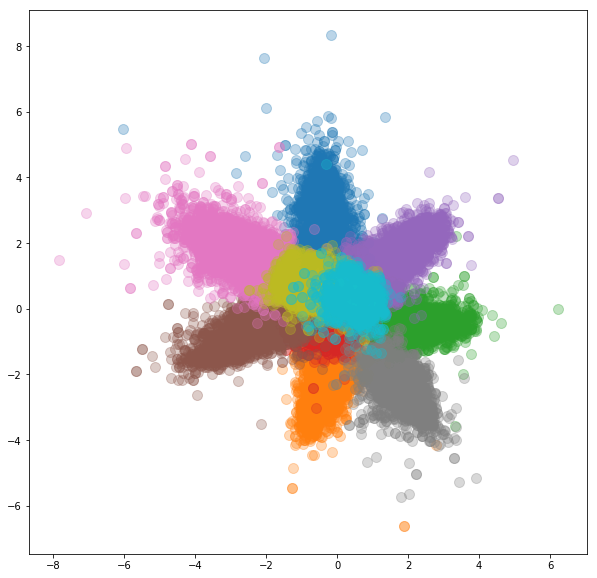

In [56]:
primary_train_embeddings, primary_train_labels = extract_embeddings(online_train_loader_primary, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(online_train_loader_helper, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)